In [28]:
import numpy as np
import pandas as pd
from scipy.sparse import csgraph
import os
import matplotlib.pyplot as plt
import seaborn as sns
import neuromaps

import sys
sys.path.append('../')
from src import data
from scipy.stats import spearmanr, rankdata, pearsonr

from netneurotools import metrics # zjistit, proč tohle nefunguje přes pip 
# (mám to stažené lokálně z Githubu a to pak funguje)

import h5py

from nilearn import plotting

# https://neuraldatascience.io/7-eeg/mne_data.html
%matplotlib widget

PLOT=True
plt.rcParams['figure.figsize'] = [10, 10]

!date -I

2024-02-01


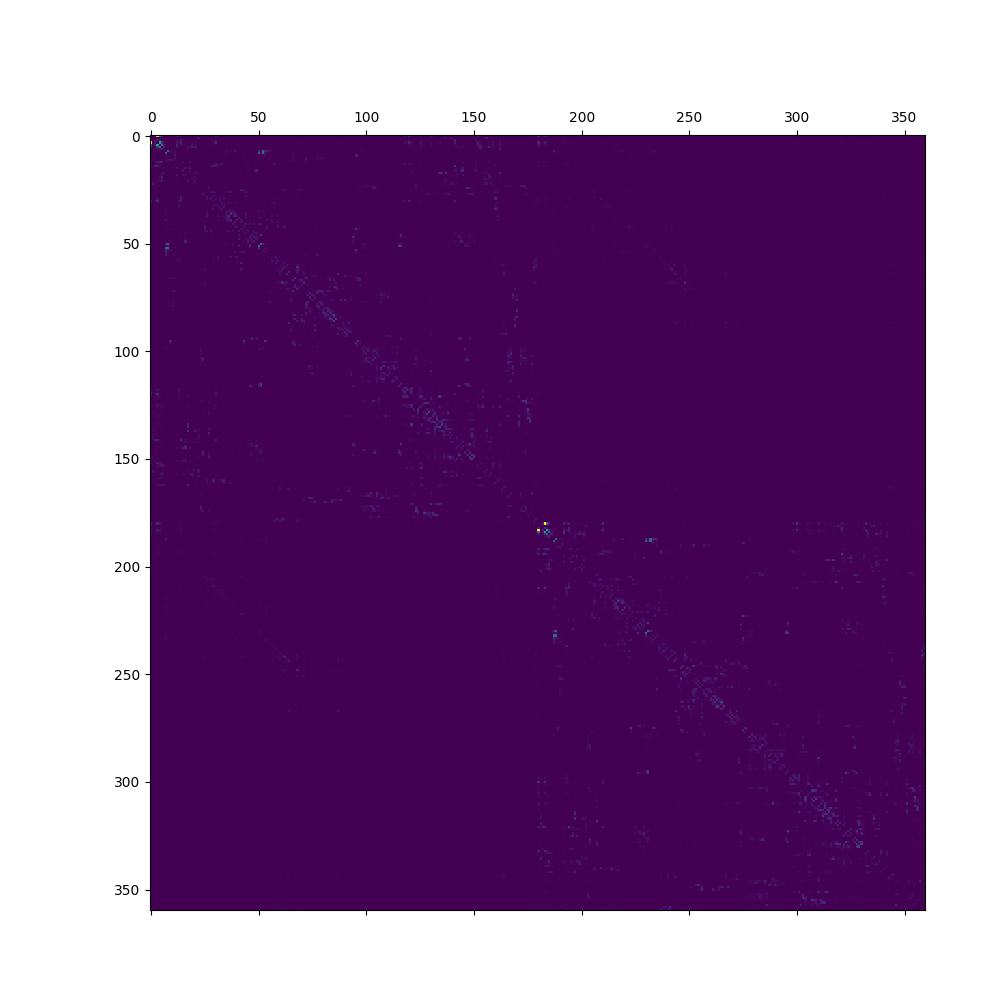

In [29]:
path_sc = '../data/external/rosen_halgren_sc/public_PLoSBio_final/averageConnectivity_axonCount.mat'
with h5py.File(path_sc, 'r') as f:
    SC = np.array(f.get('axonCount'))

plt.matshow(SC)

(array([1.2762e+05, 1.2240e+03, 4.8200e+02, 1.5800e+02, 6.6000e+01,
        1.2000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.4000e+01,
        1.2000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([       0.        ,   616273.20710739,  1232546.41421477,
         1848819.62132216,  2465092.82842954,  3081366.03553693,
         3697639.24264432,  4313912.4497517 ,  4930185.65685909,
         5546458.86396647,  6162732.07107386,  6779005.27818124,
         7395278.48528863,  8011551.69239602,  8627824.8995034 ,
         9244098.10661079,  9860371.31371817, 10476644.52082556,
        11092917.72793294, 11709190.93504033, 12325464.14214772,
        12941737.3492551 , 13558010.55636249, 14174283.76346987,
        14790556.97057726, 15406830.17768465, 16023103.38479203,
     

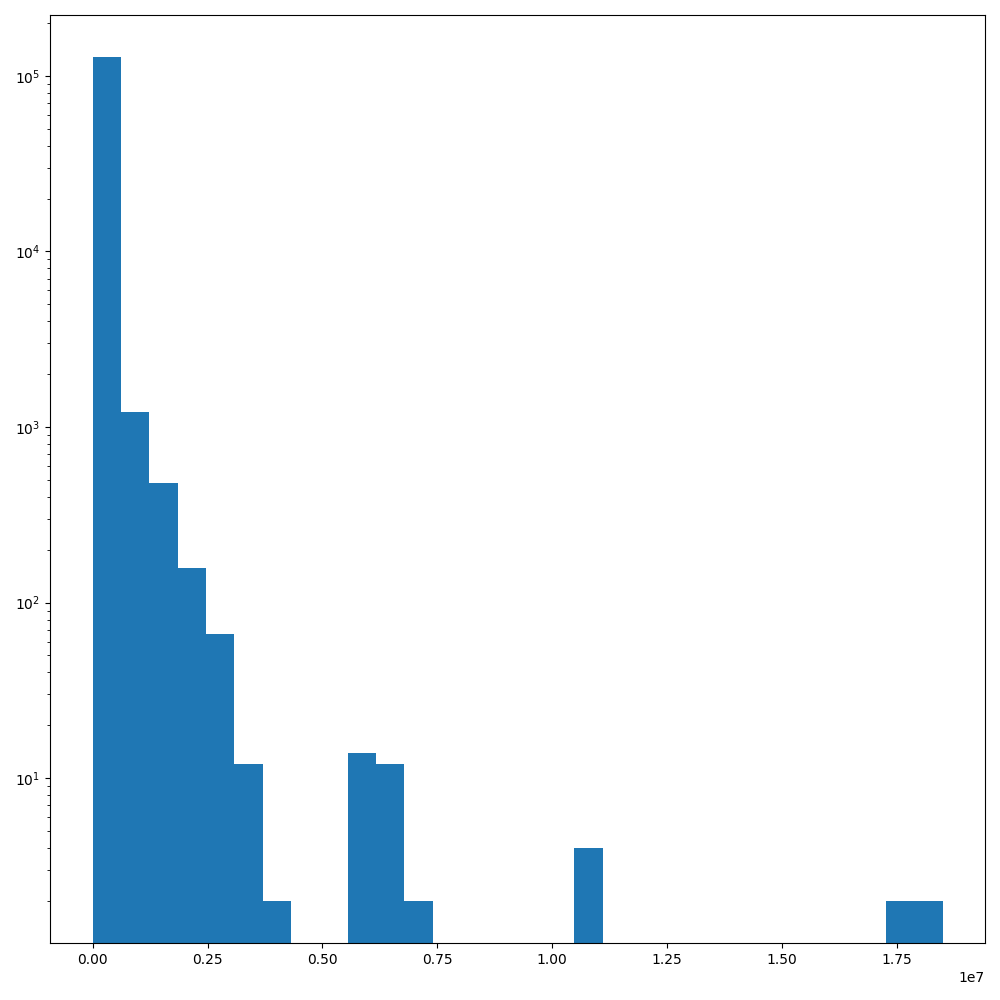

In [30]:
n_bins = 30

# Generate two normal distributions
fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist(SC.flatten(), bins=n_bins,log=True)

In [31]:
W = SC
L = np.where(SC==0.0,0,1/SC)

/tmp/ipykernel_93881/3691020451.py:2: RuntimeWarning: divide by zero encountered in divide
  L = np.where(SC==0.0,0,1/SC)


In [32]:
# load data F-TRACT
parcellation = "MNI-HCP-MMP1" 

response_probability = np.loadtxt(f'../data/external/F-TRACT/{parcellation}/probability.txt.gz')
response_amplitude = np.loadtxt(f'../data/external/F-TRACT/{parcellation}/amplitude__median.txt.gz')

print(response_probability.shape)

(360, 360)


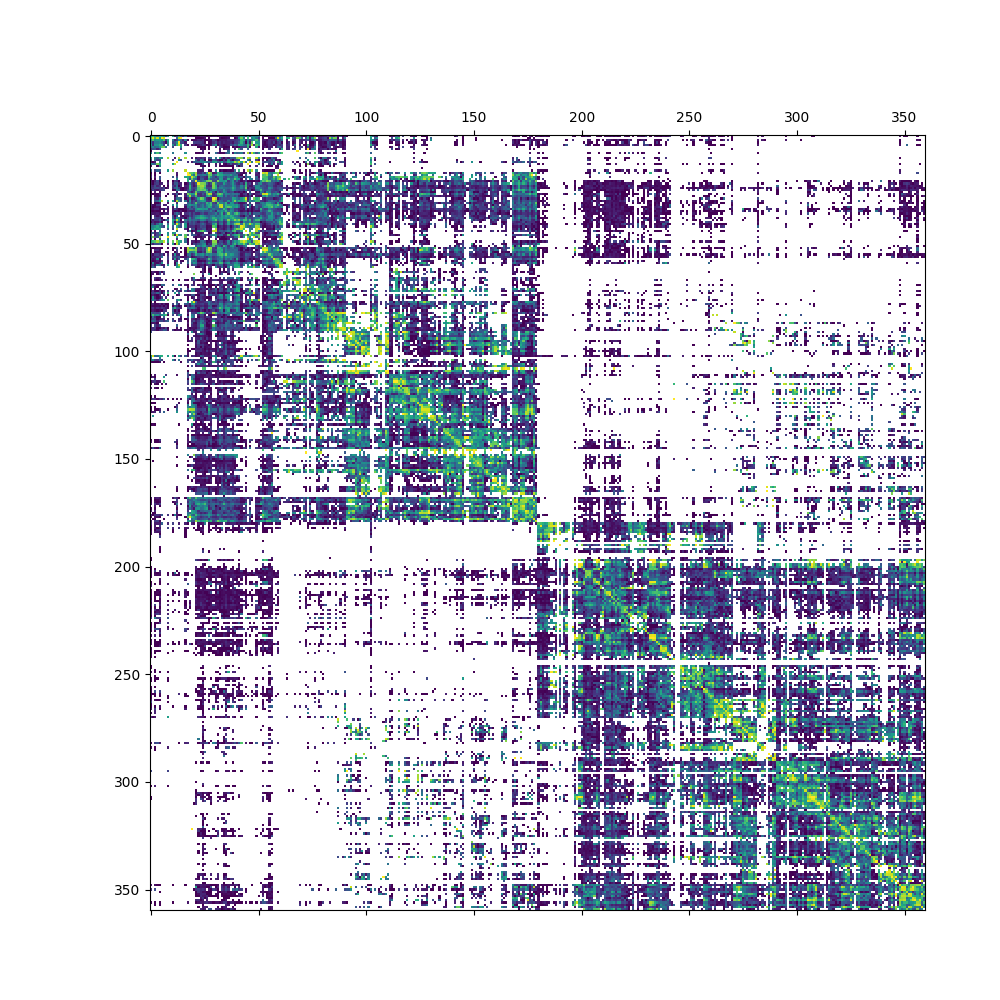

In [33]:
plt.matshow(response_probability)

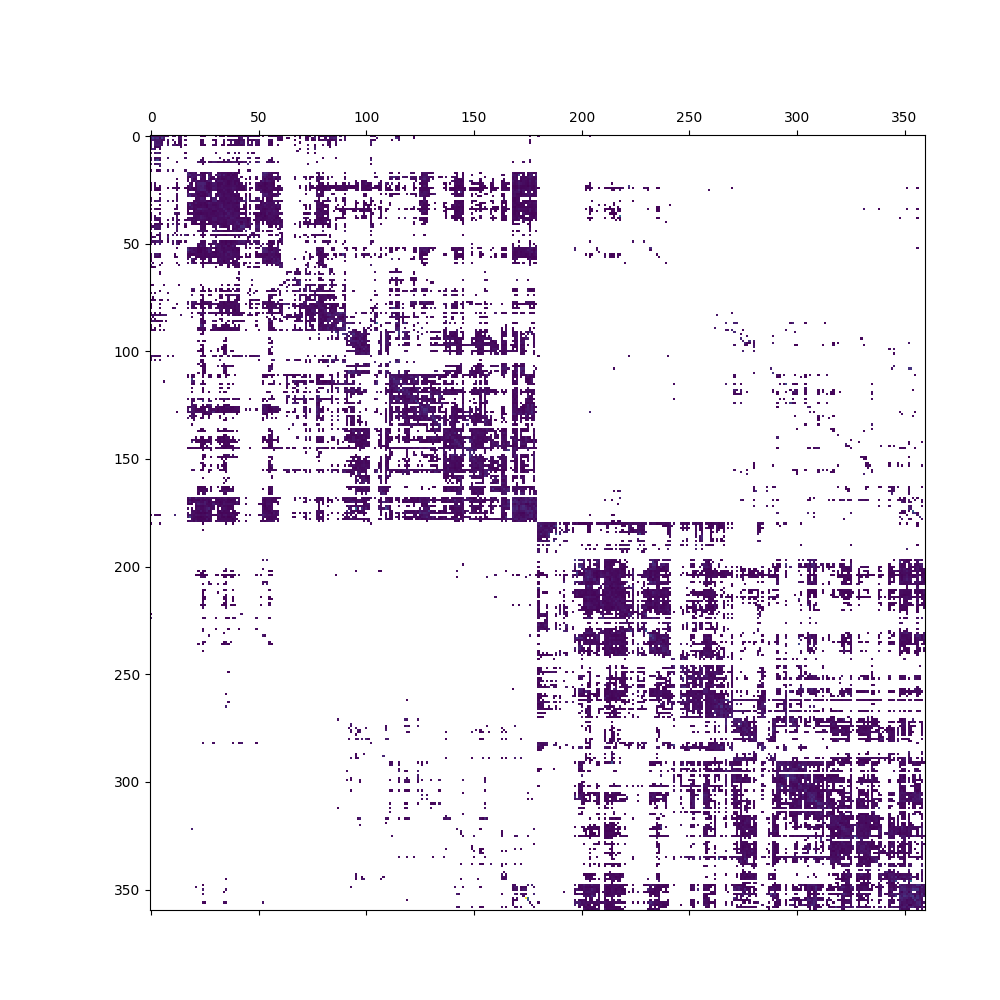

In [34]:
plt.matshow(response_amplitude)


(array([1.2706e+04, 6.8290e+03, 1.1850e+03, 2.5100e+02, 7.5000e+01,
        2.6000e+01, 1.6000e+01, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 5.194     ,  7.46463333,  9.73526667, 12.0059    , 14.27653333,
        16.54716667, 18.8178    , 21.08843333, 23.35906667, 25.6297    ,
        27.90033333, 30.17096667, 32.4416    , 34.71223333, 36.98286667,
        39.2535    , 41.52413333, 43.79476667, 46.0654    , 48.33603333,
        50.60666667, 52.8773    , 55.14793333, 57.41856667, 59.6892    ,
        61.95983333, 64.23046667, 66.5011    , 68.77173333, 71.04236667,
        73.313     ]),
 <BarContainer object of 30 artists>)

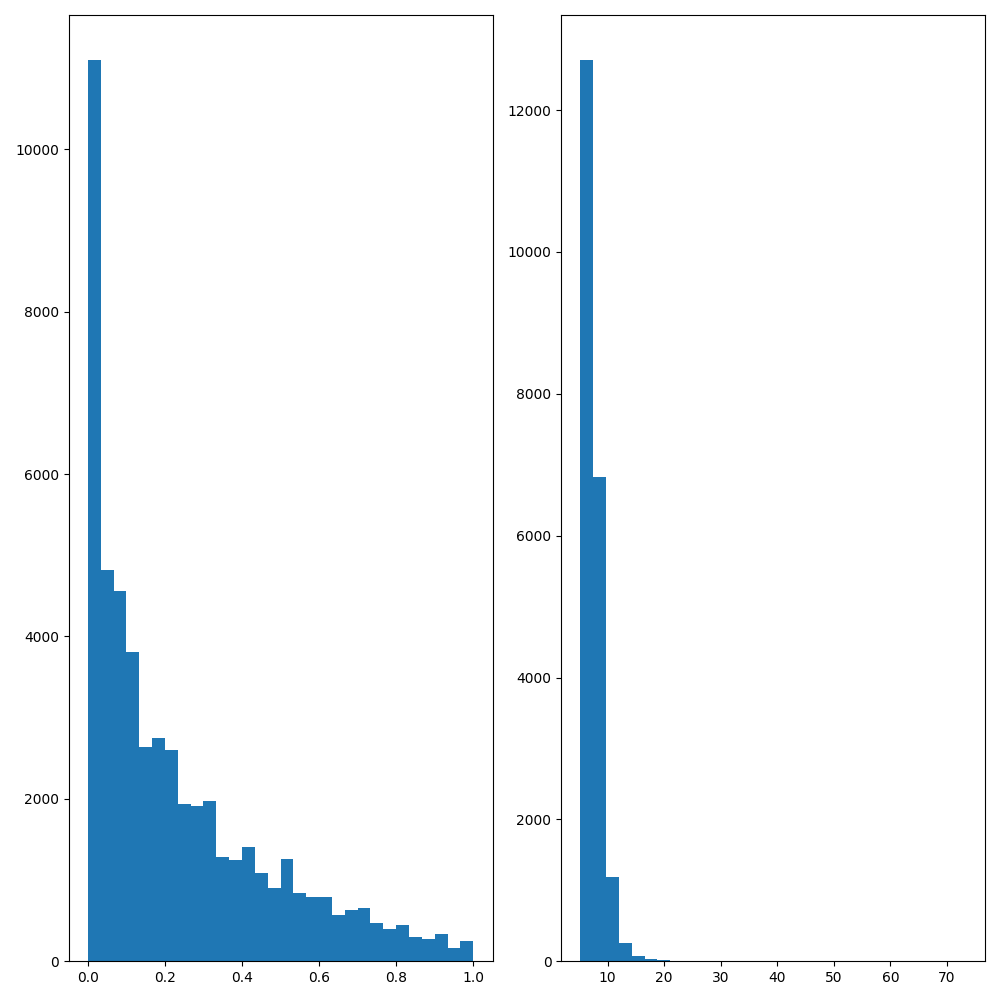

In [35]:
n_bins = 30

# Generate two normal distributions
fig, axs = plt.subplots(1, 2, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(response_probability.flatten(), bins=n_bins)
axs[1].hist(response_amplitude.flatten(), bins=n_bins)

In [36]:
with np.printoptions(threshold=np.inf):
    print(response_probability)
    print(response_amplitude)

[[0.61  0.665 0.502 0.342 0.559 0.619 0.459 0.154 0.518   nan 0.609 0.097
  0.17  0.599 0.295 0.077 0.406 0.011 0.045 0.085 0.027 0.032 0.035 0.079
  0.076 0.049 0.    0.013 0.046 0.083 0.101 0.014 0.068 0.056 0.042 0.032
  0.055 0.165 0.084 0.1   0.112 0.212 0.563 0.433 0.12  0.537 0.069 0.478
  0.396 0.418 0.357   nan 0.033 0.034 0.027 0.075 0.056 0.069 0.088 0.219
  0.126 0.31    nan 0.045 0.049 0.028 0.    0.132 0.071 0.144 0.045 0.
  0.032 0.437 0.033 0.045 0.231 0.    0.022 0.032 0.06  0.084 0.127 0.186
  0.116 0.074 0.25  0.024 0.263 0.015 0.066 0.      nan   nan   nan   nan
    nan   nan   nan   nan   nan   nan 0.598 0.347 0.101 0.043   nan   nan
    nan   nan   nan 0.    0.053 0.077 0.237 0.107   nan 0.19    nan   nan
    nan 0.048 0.042 0.      nan   nan 0.    0.    0.02    nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan   nan   nan 0.031 0.14    nan
    nan 0.      nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan   nan   n

(array([1.2762e+05, 1.2240e+03, 4.8200e+02, 1.5800e+02, 6.6000e+01,
        1.2000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.4000e+01,
        1.2000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([       0.        ,   616273.20710739,  1232546.41421477,
         1848819.62132216,  2465092.82842954,  3081366.03553693,
         3697639.24264432,  4313912.4497517 ,  4930185.65685909,
         5546458.86396647,  6162732.07107386,  6779005.27818124,
         7395278.48528863,  8011551.69239602,  8627824.8995034 ,
         9244098.10661079,  9860371.31371817, 10476644.52082556,
        11092917.72793294, 11709190.93504033, 12325464.14214772,
        12941737.3492551 , 13558010.55636249, 14174283.76346987,
        14790556.97057726, 15406830.17768465, 16023103.38479203,
     

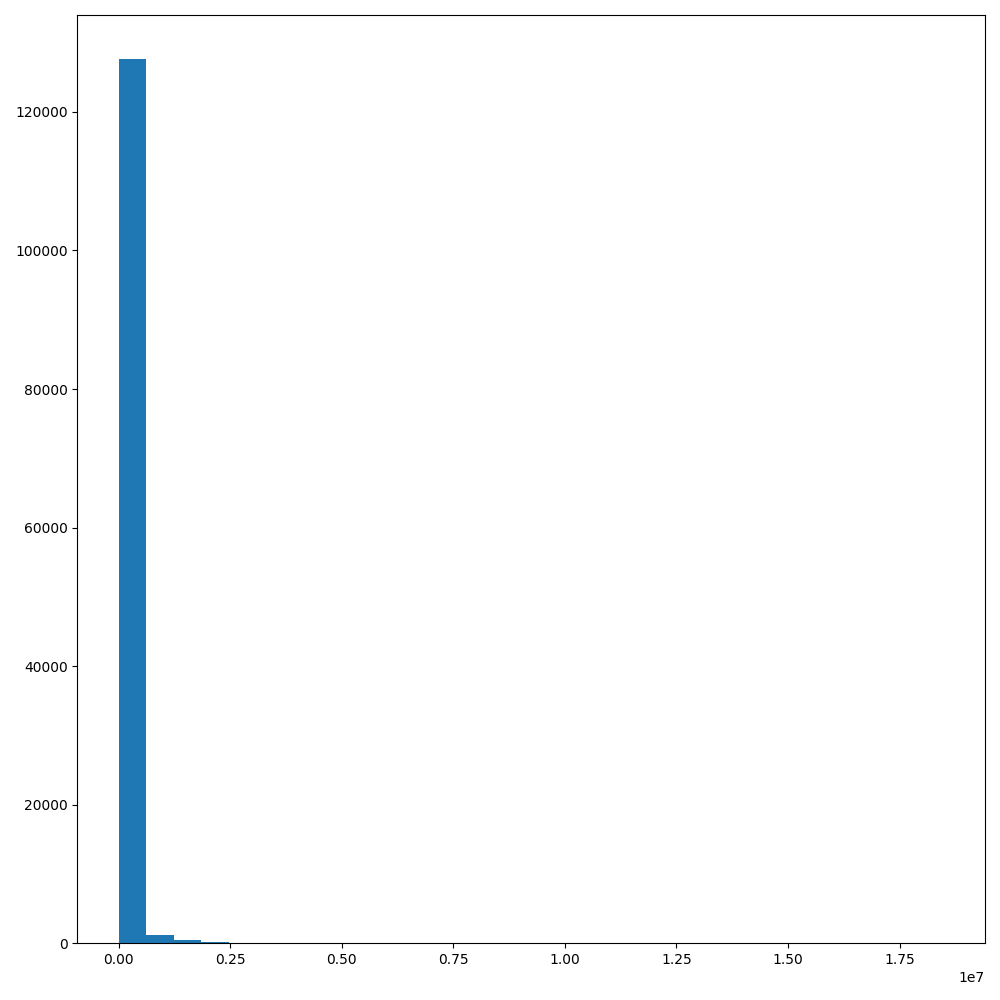

In [37]:
n_bins = 30

# Generate two normal distributions
fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist(W.flatten(), bins=n_bins)


In [38]:
PLOT = False

In [39]:
# shortcut for correlation of X with response probability and amplitude 
rpf = response_probability.flatten()
raf = response_amplitude.flatten()

def coor_with_response(X):
    r_probability = spearmanr(X.flatten(),rpf,nan_policy='omit')
    r_amplitude = spearmanr(X.flatten(),raf,nan_policy='omit')

    print(f"Correlation with response probabilty: {r_probability.statistic:.3f} (p={r_probability.pvalue:.3f})")
    print(f"Correlation with response amplitude: {r_amplitude.statistic:.3f} (p={r_amplitude.pvalue:.3f})")

    if PLOT:
        coor_plot(X)

def coor_plot(X):
    rpf_ranks = rankdata(rpf[~np.isnan(rpf)], method='ordinal')
    X_ranks_rpf = rankdata(X.flatten()[~np.isnan(rpf)], method='ordinal')
    df_rpf = pd.DataFrame({'x':X_ranks_rpf,'y':rpf_ranks})
    sns.lmplot(data=df_rpf,x='x',y='y');

    raf_ranks = rankdata(raf[~np.isnan(raf)], method='ordinal')
    X_ranks_raf = rankdata(X.flatten()[~np.isnan(raf)], method='ordinal')
    df_raf = pd.DataFrame({'x':X_ranks_raf,'y':raf_ranks})
    sns.lmplot(data=df_raf,x='x',y='y');

In [40]:
coor_with_response(W) 

Correlation with response probabilty: 0.100 (p=0.000)
Correlation with response amplitude: 0.048 (p=0.000)


In [41]:
coor_with_response(L) 

Correlation with response probabilty: -0.132 (p=0.000)
Correlation with response amplitude: -0.116 (p=0.000)


In [42]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(L)
shorest_path_eff = np.divide(1,shorest_paths)

if PLOT:
    plt.matshow(shorest_path_eff)

coor_with_response(shorest_path_eff)

/tmp/ipykernel_93881/2515200096.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


Correlation with response probabilty: 0.164 (p=0.000)
Correlation with response amplitude: 0.092 (p=0.000)


In [43]:
com = metrics.communicability_wei(W)

coor_with_response(com)

Correlation with response probabilty: 0.131 (p=0.000)
Correlation with response amplitude: 0.050 (p=0.000)


In [44]:
SI = metrics.search_information(W,L)

if PLOT:
    plt.matshow(SI)

coor_with_response(SI)

Correlation with response probabilty: -0.187 (p=0.000)
Correlation with response amplitude: -0.083 (p=0.000)


In [45]:
# https://netneurolab.github.io/netneurotools/_modules/netneurotools/metrics.html#diffusion_efficiency
diffusion = metrics.diffusion_efficiency(W)[1] # tahle funkce určitě má dostat SC, a ne délky L

if PLOT:
    plt.matshow(diffusion)

coor_with_response(diffusion)

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


Correlation with response probabilty: -0.026 (p=0.000)
Correlation with response amplitude: 0.003 (p=0.684)


In [46]:
# tady té funkci možná dávám špatný vstup?
_,_,nav_paths,_,_ = metrics.navigation_wu(L, W)
nav_eff = np.divide(1,nav_paths)

if PLOT:
    plt.matshow(nav_eff)

coor_with_response(nav_eff)

/tmp/ipykernel_93881/2427672740.py:3: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)


Correlation with response probabilty: 0.118 (p=0.000)
Correlation with response amplitude: 0.084 (p=0.000)
